# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np 
from glob import glob

# load files from human and dogs 
human_files = np.array(glob('/data/lfw/*/*'))
dog_files = np.array(glob('/data/dog_images/*/*/*'))

#print number of images in each dataset

print('There are {} total human images.'.format(len(human_files)))
print('There are {} total dog images.'.format(len(dog_files)))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
# import liberaries
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from PIL import ImageFile
from PIL import Image
import PIL

ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print('cuda is avaliable ... ' )
    
print('PyToch Version : ',torch.__version__)

cuda is avaliable ... 
PyToch Version :  0.4.0


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

> The following code example will use pretrained **Haar cascade models** to detect faces in an image.
First, a `CascadeClassifier` is created and the necessary XML file is loaded using the `CascadeClassifier`::load method. Afterwards, the detection is done using the `CascadeClassifier`,`detectMultiScale` method, which returns boundary rectangles for the detected faces.

Numbrer of faces detected = 1


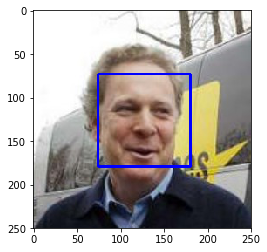

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 1. extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
                         
# 2. load image (rgb)
img_rgb = cv2.imread(human_files[125])
                                     
#3. convert image to grayscale
img_gray =  cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
                                     
#4. find faces in image
faces = face_cascade.detectMultiScale(img_gray)
                                     
#5. print num of faces detected  in image
print('Numbrer of faces detected = {}'.format(len(faces)))
                                     
#6. get bounding box for each detected face
for x, y, w, h in faces:
    # add bounded box to the colored image
    # cv2.rectangle(image, start_point, end_point, color, thickness)
    cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (255,0,0) , 2)
    
#7. Convert RGB image to RGB image for plotting
face_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
#8. display the image, along with bounding box
plt.imshow(face_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
#from mtcnn import MTCNN

def face_detector(img_path):
    
    img_rgb = cv2.imread(img_path)
    img_gray= cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(img_gray)
    
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
The face detector isn't perfect as it detect face in 16% of dog images. and it fails to detect 4% of human images.

In [5]:
from tqdm import tqdm_notebook as tqdm

def face_detector_performance(files_short , file_name):
    counter = []
    incorrect_imgs = []
    
    [(incorrect_imgs.append(file)) if ((face_detector(file))^bool(file_name =='human')) else (counter.append(1))for file in tqdm(files_short) ]

    return sum(counter), incorrect_imgs   

In [6]:
total = 100
human_files_short = human_files[:total]
dog_files_short = dog_files[:total]

n_faces_in_human_files, error_list_human_files  = face_detector_performance(human_files_short, 'human')
n_faces_in_dog_files  , error_list_dog_files    = face_detector_performance(dog_files_short, 'dog')

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [7]:

print('Number of faces detected in human files short is {}/{} \t\t cost = {}%'.format(n_faces_in_human_files, total,
                                                                                           100-n_faces_in_human_files))
print('Number of faces detected in dog files short is {}/{}   \t\t cost = {}%'.format(100-n_faces_in_dog_files, total,
                                                                                         100-n_faces_in_dog_files))

Number of faces detected in human files short is 96/100 		 cost = 4%
Number of faces detected in dog files short is 16/100   		 cost = 16%


In [8]:
error_list_human_files
#error_list_dog_files 

['/data/lfw/Rafael_Vinoly/Rafael_Vinoly_0001.jpg',
 '/data/lfw/Julianne_Moore/Julianne_Moore_0002.jpg',
 '/data/lfw/Nick_Price/Nick_Price_0001.jpg',
 '/data/lfw/Clive_Lloyd/Clive_Lloyd_0001.jpg']

In [9]:
# Display images
def show_erroneous (my_list, row, col, size):
    plt.figure(figsize=(20,20))   

    for i, img in enumerate(my_list):
              
        image = PIL.Image.open(img)
        plt.subplot(row,col,i+1)
        plt.title(img.split('/')[-1].split('.')[0] , size = size)
        plt.axis('off')
        plt.imshow(image);
        print


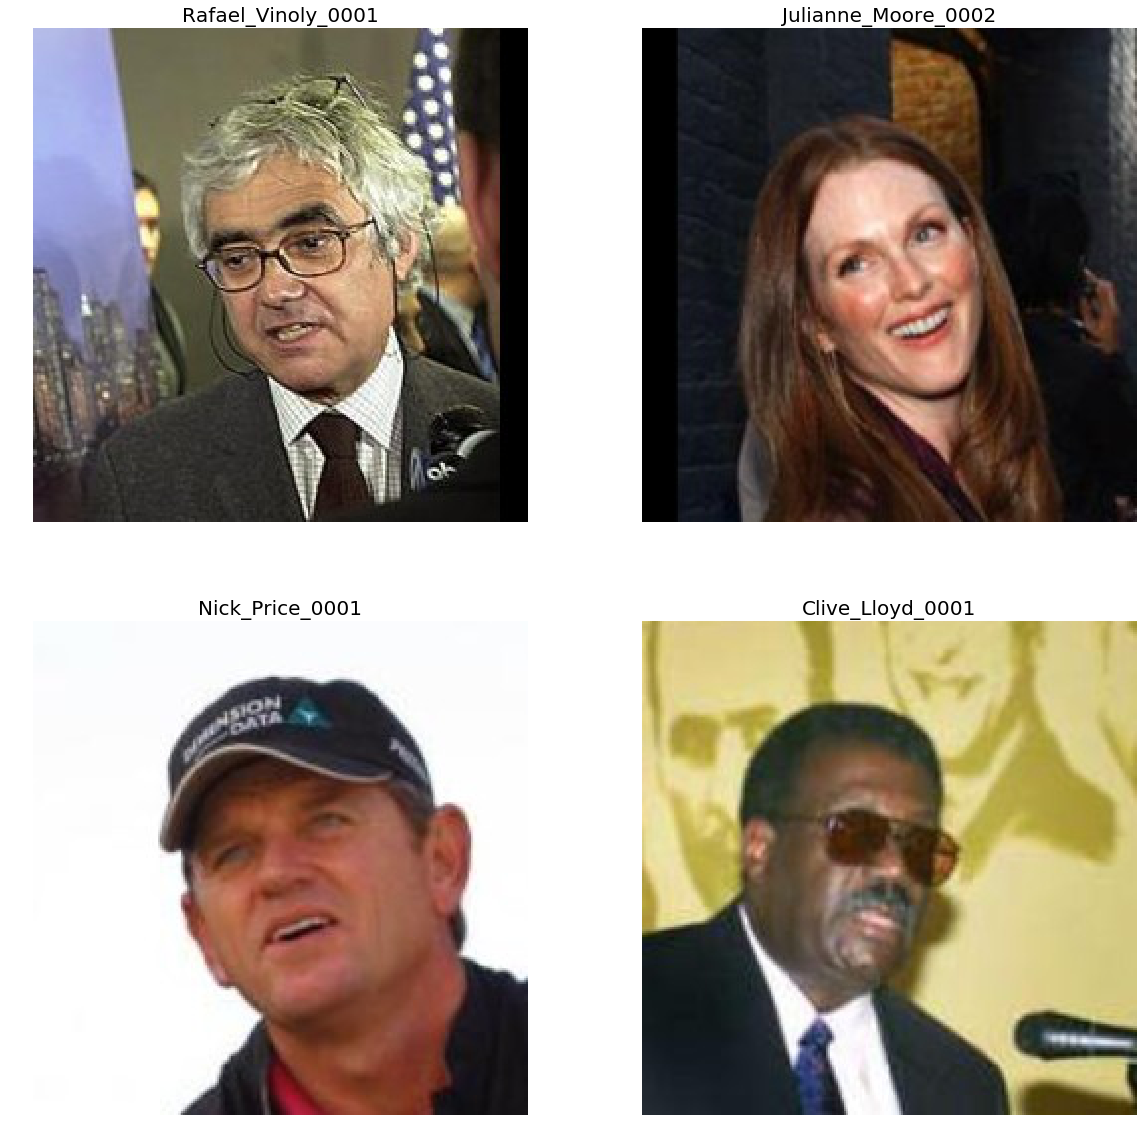

In [10]:
# print detector errors form human files 
show_erroneous(error_list_human_files, 2,2,20)

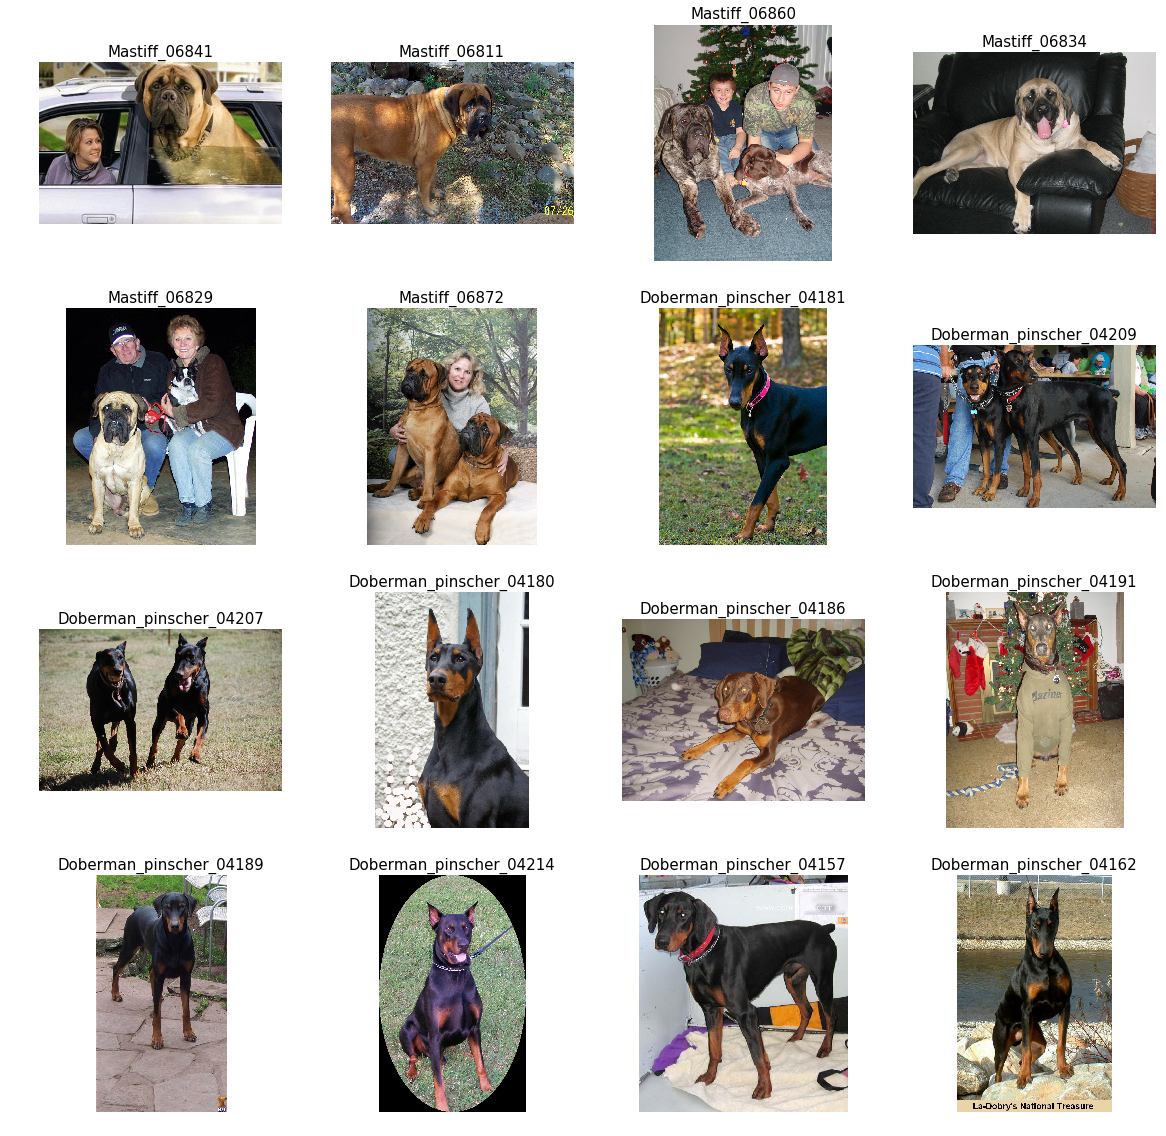

In [11]:
# print detector errors form dog files 
show_erroneous(error_list_dog_files, 4,4,15)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [8]:
VGG16_model = models.vgg16(pretrained=True)

if use_cuda:
    VGG16_model = VGG16_model.cuda() 
else:
    print('cuda NOT avaliable...')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:14<00:00, 36977995.12it/s]


In [9]:
print(VGG16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
from torch.autograd import Variable

def predict_breed(img_path,model):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    # 1. Load image from its path
    image = Image.open(img_path)
    
    # 2. pre-process an image from the given img_path (convert image to tensor)
    data_transform  = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])
    
    
    tensor_img = data_transform(image).float()
    tensor_img = tensor_img.unsqueeze(0)
    tensor_img = Variable(tensor_img)
    # 3. Move to cuda
    if use_cuda:
        tensor_img = tensor_img.cuda()
    
    #4. make prediction and move it to cuda
    output =  model(tensor_img)
    
    #5. Move to cpu
    if use_cuda:
        output = output.cpu()
        
    #5. Return the *index* of the predicted class for that image
    
    torch.no_grad()
    index = output.data.numpy().argmax() 
    
    return index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model):

    index= predict_breed(img_path, model)          
    
    return  (151 <= index and index <= 268)


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* What percentage of the images in human_files_short have a detected dog? 2%
* What percentage of the images in dog_files_short have a detected dog? 99%

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm_notebook as tqdm

def dog_detector_performance(files_short , file_name, model):
    counter = []
    incorrect_imgs = []
    
    [(incorrect_imgs.append(file)) if (bool(dog_detector(file, model))^bool(file_name =='dog')) else (counter.append(1))for file in tqdm(files_short) ]

    return sum(counter), incorrect_imgs   

In [13]:


total = 100
human_files_short = human_files[:total]
dog_files_short = dog_files[:total]

n_faces_in_human_files, error_list_human_files  = dog_detector_performance(human_files_short, 'human',VGG16_model)
n_dogs_in_dog_files  , error_list_dog_files     = dog_detector_performance(dog_files_short, 'dog',VGG16_model)

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [14]:
n_dogs_in_human_files = total - n_faces_in_human_files
print('Number of dogs detected in human files short is {}/{} images \t\t cost = {}%'.format(n_dogs_in_human_files, total,
                                                                                           n_dogs_in_human_files))
print('Number of dogs detected in dog files short is {}/{} images \t\t cost = {}%'.format(n_dogs_in_dog_files, total,
                                                                                         100-n_dogs_in_dog_files))

Number of dogs detected in human files short is 0/100 images 		 cost = 0%
Number of dogs detected in dog files short is 100/100 images 		 cost = 0%


In [19]:
# print detector errors form human files 
show_erroneous(error_list_human_files, 2,2 ,25);

In [20]:
# print detector errors form dog files 
show_erroneous(error_list_dog_files, 2,5,15);

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

### Report the performance using squeezenet1_1.

In [21]:
import torchvision.models as models

squeezenet11_model = models.squeezenet1_1(pretrained = True)

if use_cuda:
    squeezenet11_model = squeezenet11_model.cuda() 
else:
    print('cuda NOT avaliable...')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.torch/models/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:00<00:00, 24310861.37it/s]


In [22]:
print(squeezenet11_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [23]:
total = 100
human_files_short = human_files[:total]
dog_files_short = dog_files[:total]

n_faces_in_human_files, error_list_human_files  = dog_detector_performance(human_files_short, 'human',squeezenet11_model)
n_dogs_in_dog_files   , error_list_dog_files    = dog_detector_performance(dog_files_short, 'dog',squeezenet11_model)

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [15]:
n_dogs_in_human_files = total - n_faces_in_human_files

print('Number of dogs detected in human files short is {}/{}   \t\t cost = {}%'.format(n_dogs_in_human_files, total,
                                                                                           n_dogs_in_human_files))
print('Number of dogs detected in dogs files short is {}/{}     \t\t cost = {}%'.format(n_dogs_in_dog_files, total,
                                                                                         100-n_dogs_in_dog_files))

Number of dogs detected in human files short is 0/100   		 cost = 0%
Number of dogs detected in dogs files short is 100/100     		 cost = 0%


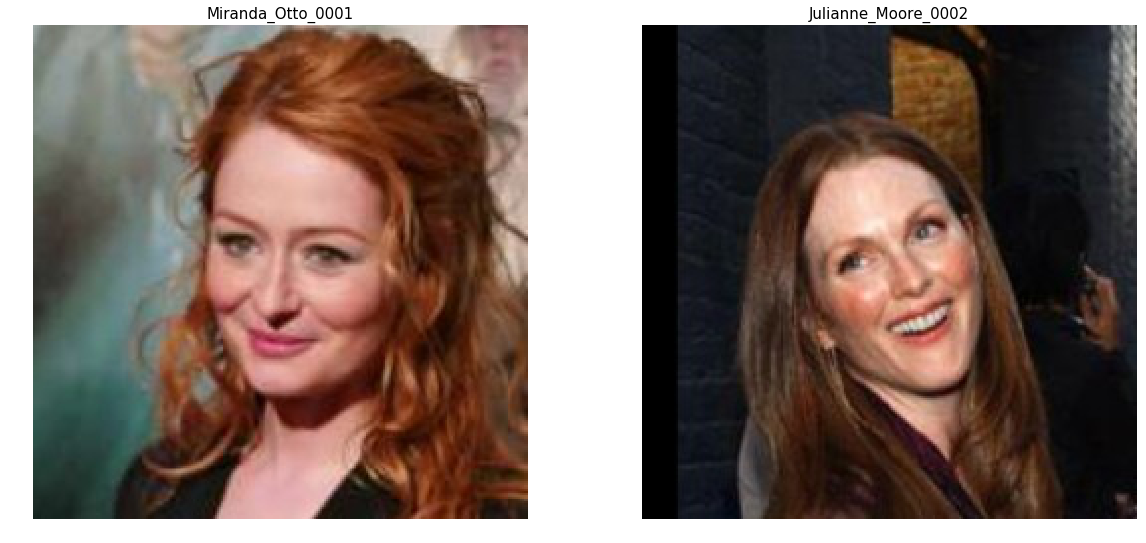

In [25]:
show_erroneous(error_list_human_files, 2, 2,15)

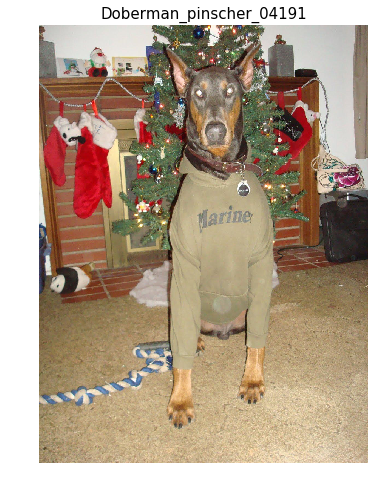

In [26]:
show_erroneous(error_list_dog_files, 2, 3,15)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador

<img src="images/Labrador_retriever_06457.jpg" width="150">  <img src="images/Labrador_retriever_06455.jpg" width="240"> <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [149]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import random
import os

In [150]:
## Specify appropriate transforms
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(256),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
data_dir = '/data/dog_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}
    
loaders_data = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 20,
                                              shuffle = True, num_workers = 0)
                  for x in ['train', 'valid', 'test']}


Initializing Datasets and Dataloaders...


In [151]:
loaders_data

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe125bba7b8>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe125bbad68>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe125bba080>}

In [152]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6680
     Root Location: /data/dog_images/train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomRotation(degrees=(-20, 20), resample=False, expand=False)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'valid': Dataset ImageFolder
     Number of datapoints: 835
     Root Location: /data/dog_images/valid
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(224, 224))
                              ToTensor()
                              Normalize(mean=[0

In [153]:
# Some statistics
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

classes_name = image_datasets['train'].classes
n_classes = len(classes_name)


print('Number of train images = '     ,dataset_sizes['train']  ) 
print('Number of validation images = ',dataset_sizes['valid']  )
print('Number of test data images = ' ,dataset_sizes['test']   )
print('Number of classes = '          ,n_classes  )

Number of train images =  6680
Number of validation images =  835
Number of test data images =  836
Number of classes =  133


### Show imges after augmatation

In [154]:
def imshow(img):
    
    img = img.transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
##############################################################3
def show_shample_of_images (loaders_data, row, n_images, fig_size = (25, 5)):
    images, classes = next(iter(loaders_data))
    images = images.numpy() 
    fig = plt.figure(figsize=fig_size)

    for i in np.arange(n_images):
        ax = fig.add_subplot(row, n_images/row, i+1, xticks=[], yticks=[])
        imshow(images[i])
        class_names = image_datasets['train'].classes
        ax.set_title(class_names[classes[i]].split(".")[1])

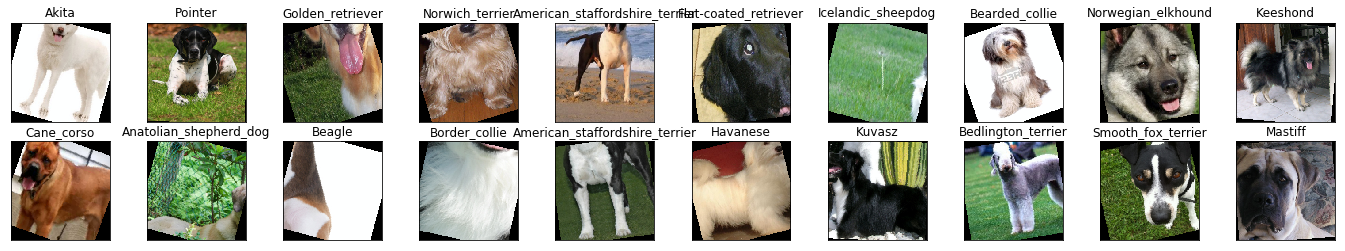

In [33]:
show_shample_of_images(loaders_data['train'], 2, 20, fig_size = (24, 4))

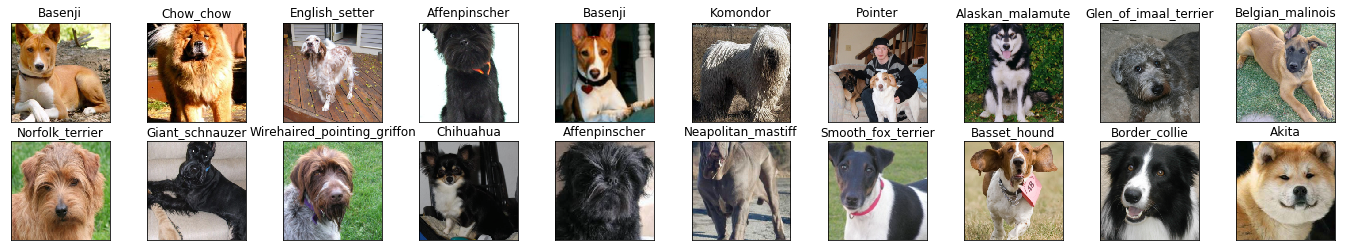

In [34]:
show_shample_of_images(loaders_data['valid'], 2, 20, fig_size = (24, 4))

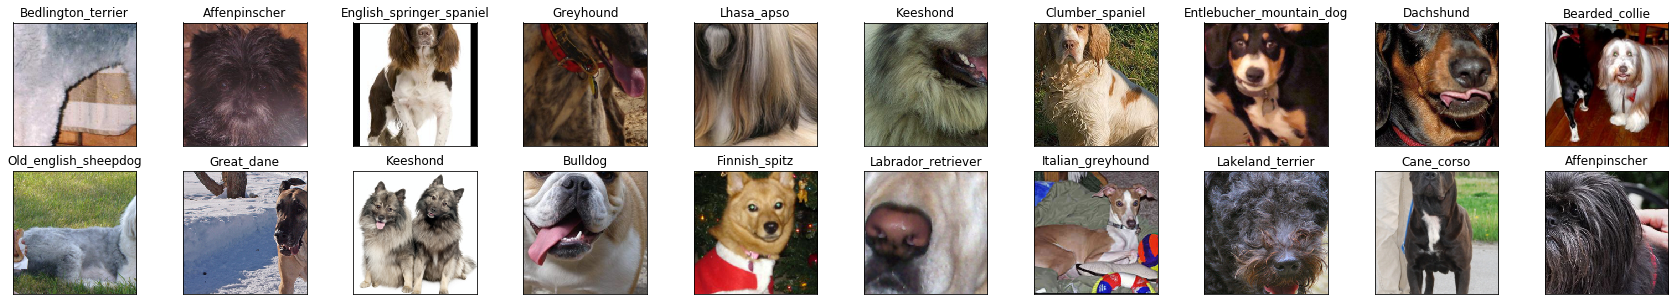

In [35]:
show_shample_of_images(loaders_data['test'], 2, 20, fig_size = (30, 5))

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 
1. Test and Validation datasets:
   
   - Extract a 224 × 224 pixels section from 256 × 256 pixels using **Resize**.
   - resized to (256, 256) using **CenterCrop**.
      - by resetting the images width and height.
   - Normalization by **[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]**.
   
2. Train dataset  : 

   - Extract a 224 × 224 pixels section from 256 × 256 pixels using **RandomResizedCrop**.
   - Random Rotation by angle = 20 using **RandomRotation(20)**.
   - Random Horizontal Flip using **RandomHorizontalFlip()**.
   - Normalization by **[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]**.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [83]:
!pip install torchsummary 

In [177]:
conv_channels = {
             'layer0'  :3, 
             'layer1'  :16,
             'layer2'  :32,
             'layer3'  :64,
             'layer4'  :128,
             'layer5'  :256,
            }

hparameters={
             'n_batches'  : 128,
             'n_epochs'   : 50,
             'n_fc1_nodes' : 4096 ,
             'n_fc2_nodes' : 1024,
             'learning_rate' :0.01 ,
             'momentum'      : 0.9,
            }

hparameters['n_classes'] = n_classes

hparameters

{'n_batches': 128,
 'n_epochs': 50,
 'n_fc1_nodes': 4096,
 'n_fc2_nodes': 1024,
 'learning_rate': 0.01,
 'momentum': 0.9,
 'n_classes': 133}

In [199]:
# define the CNN architecture

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define Convolution layers 
        self.conv1 = nn.Conv2d (conv_channels['layer0'], conv_channels['layer1'], kernel_size = 3, padding = 1 , stride = 1)  
        self.conv2 = nn.Conv2d (conv_channels['layer1'], conv_channels['layer2'], kernel_size = 3, padding = 1 , stride = 1)  
        self.conv3 = nn.Conv2d (conv_channels['layer2'], conv_channels['layer3'], kernel_size = 3, padding = 1 , stride = 1) 
        self.conv4 = nn.Conv2d (conv_channels['layer3'], conv_channels['layer4'], kernel_size = 3, padding = 1 , stride = 1) 
        self.conv5 = nn.Conv2d (conv_channels['layer4'], conv_channels['layer5'], kernel_size = 3, padding = 1 , stride = 1) 
        
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        
        # Define BatchNormalization 
        self.bn_1 = nn.BatchNorm2d(conv_channels['layer1'])
        self.bn_2 = nn.BatchNorm2d(conv_channels['layer2'])
        self.bn_3 = nn.BatchNorm2d(conv_channels['layer3'])
        self.bn_4 = nn.BatchNorm2d(conv_channels['layer4'])
        self.bn_5 = nn.BatchNorm2d(conv_channels['layer5'])
        
        ## Define fully connected layers
        
        self.fc1 = nn.Linear(conv_channels['layer5']*7*7, hparameters['n_fc1_nodes'])
        self.fc2 = nn.Linear(hparameters['n_fc1_nodes']  , hparameters['n_fc2_nodes'])
        self.output = nn.Linear( hparameters['n_fc2_nodes'], hparameters['n_classes'])
    
    def forward(self, x):
####################### Define forward behavior ######################################
                        #CONV_1
        x = F.relu(self.conv1(x))           #=> img = (224, 224)  n_channels : 3 ==> 16
        x = self.bn_1(self.pool(x))         #=> img = (112, 112)  n_channels = 16
        
                        #CONV_2
        x = F.relu(self.conv2(x))           #=> img = (112, 112)  n_channels : 16 ==> 32
        x = self.bn_2(self.pool(x))         #=> img = (56, 56)    n_channels = 32
        
                        #CONV_3
        x = F.relu(self.conv3(x))           #=> img = (56, 56)    n_channels : 32 ==> 64
        x = self.bn_3(self.pool(x))         #=> img = (28, 28)    n_channels = 64
        
                        #CONV_4
        x = F.relu(self.conv4(x))            #=> img = (28, 28)    n_channels : 64 ==> 128
        x = self.bn_4(self.pool(x))          #=> img = (14, 14)    n_channels = 128
        
                        #CONV_5
        x = F.relu(self.conv5(x))             #=> img = (14, 14)    n_channels : 128 ==> 256
        x = self.bn_5(self.pool(x))           #=> img = (7, 7)      n_channels = 256
    
####################### FLATTEN ####################################################                       
        x = x.view(x.size(0), conv_channels['layer5']*7*7) # n_channels * weidth * height 
#####################################################################################

                        #FULLY-CONNECTED_1 (HIDDEN)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
                        #FULLY-CONNECTED_2 (HIDDEN)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
                        #FULLY-CONNECTED_3 (OUTPUT)
        x = self.output(x)
        
        return x
#####################################################################################

# Create new model
model_scratch = Net()

In [200]:
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [201]:
from torchsummary import summary

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
       BatchNorm2d-3         [-1, 16, 112, 112]              32
            Conv2d-4         [-1, 32, 112, 112]           4,640
         MaxPool2d-5           [-1, 32, 56, 56]               0
       BatchNorm2d-6           [-1, 32, 56, 56]              64
            Conv2d-7           [-1, 64, 56, 56]          18,496
         MaxPool2d-8           [-1, 64, 28, 28]               0
       BatchNorm2d-9           [-1, 64, 28, 28]             128
           Conv2d-10          [-1, 128, 28, 28]          73,856
        MaxPool2d-11          [-1, 128, 14, 14]               0
      BatchNorm2d-12          [-1, 128, 14, 14]             256
           Conv2d-13          [-1, 256, 14, 14]         295,168
        MaxPool2d-14            [-1, 25

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

- 5 CONV layers are used with kernal size = 3, stride = 1 and padding = 1 
- Channels used (16, 32, 64, 128, 256).
- Each CONV followed by a max pooling layer of 2*2.
- convert multi-dimantial to vector(flatten).
- Two fully connected layer.
- Relu activations are used after each layers except the last one.
- Dropout is applied with the probability of 0.3 after each fully connected layer .

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [202]:
### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters() , lr = hparameters['learning_rate'], momentum=hparameters['momentum'])
scheduler = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=100, gamma=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [203]:
import time 
import numpy as np

def train(num_epochs,model, dataloaders, criterion, optimizer, use_cuda, save_path):
    
    val_acc_history=[]
    val_loss_history=[]
    
    train_acc_history=[]
    train_loss_history=[]
    
    learning_rate = []
    
    valid_loss_min = np.Inf
    best_loss = np.Inf
    no_improve = 0
    early_stop = False
    
    since = time.time()
    for epoch in range(1, num_epochs + 1):
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                
                if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        scheduler.step()
                        optimizer.step()
                        
                    if  batch_idx % 4 == 0 :
                        print('-',end='')

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('\n{} epoch \t Loss: {:.6f} \t Accuracy: {:.6f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                print('-'*84)
                print('\nValidation loss decreased ({:.6f} ----> {:.6f})  Saving model...'.format(best_loss, epoch_loss))
                
                best_loss = epoch_loss
                torch.save(model.state_dict(), save_path)
                no_improve = 0
                
            elif phase == 'valid' and epoch_loss > best_loss:
                no_improve += 1
            
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            if epoch > 2 and no_improve == 3:
                print('Early stopping!' )
                early_stop = True
            else:
                early_stop = False

            # Check early stopping condition
        if early_stop:
            print("Stopped")
            break
        
        # get learning rate 
        
        for param_group in optimizer.param_groups:
            learning_rate.append(param_group['lr'])
    
        epoch_time = time.time() - start_epoch
        print('Epoch takes {:.0f} min {:.0f} sec'.format(epoch_time // 60,epoch_time % 60))
        print('='*84)

    time_elapsed = time.time() - since
    print('='*84)
    print('Training complete in {:.0f} min {:.0f} sec'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Loss: {:6f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(save_path))
    
    history = {'train_acc' :train_acc_history,
               'train_loss':train_loss_history,
               'val_acc'   :val_acc_history,
               'val_loss'  :val_loss_history,
               'learning_rate' : learning_rate}
    
    return history , model

In [204]:
# train the model
loaders_scratch = loaders_data

history, model_scratch = train(hparameters['n_epochs'],model_scratch, 
                               loaders_scratch, criterion_scratch, 
                               optimizer_scratch, use_cuda, 'model_scratch.pt')

model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch 1/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 4.701637 	 Accuracy: 0.028144
-----------
valid epoch 	 Loss: 4.395593 	 Accuracy: 0.039521
------------------------------------------------------------------------------------

Validation loss decreased (inf ----> 4.395593)  Saving model...
Epoch takes 1 min 58 sec
Epoch 2/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 4.438430 	 Accuracy: 0.042066
-----------
valid epoch 	 Loss: 4.240167 	 Accuracy: 0.061078
------------------------------------------------------------------------------------

Validation loss decreased (4.395593 ----> 4.240167)  Saving model...
Epoch takes 1 min 58 sec
Epoch 3/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 4.237231 	 Accuracy: 0.065569
-----------
valid epoch 	 Loss: 3.996541 	 Accuracy: 0.088623
---------------------

### Visualizing Convolutional Layer Filters

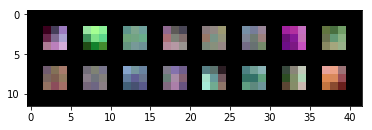

In [28]:
from torchvision.utils import make_grid

kernels = model_scratch.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [205]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        print('-',end='')
                    
    print('\nTest Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

------------------------------------------
Test Loss: 3.425020


Test Accuracy: 17% (145/836)


### (VISUALIZATION) visual accuarcy and losses using matplotlib

In [206]:
np.save('model_scratch_history.npy', history) 

#history = np.load('model_scratch_history.npy',allow_pickle='TRUE').item()

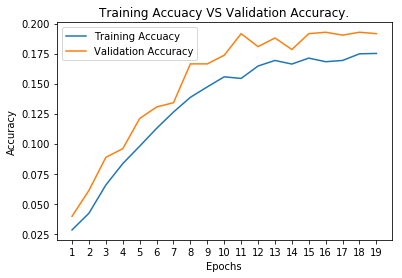

Image saved!


In [229]:
train_acc = []
valid_acc = []

train_acc = [acc.cpu().numpy() for acc in history['train_acc']]
valid_acc = [acc.cpu().numpy() for acc in history['val_acc']]

plt.title("Training Accuacy VS Validation Accuracy.")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,20),train_acc,label="Training Accuacy")
plt.plot(range(1,20),valid_acc,label="Validation Accuracy")

plt.xticks(np.arange(1,20 , 1.0))
plt.legend()
plt.show()

plt.savefig('Training Accuacy VS Validation Accuracy - model scratch.png')
print('Image saved!')

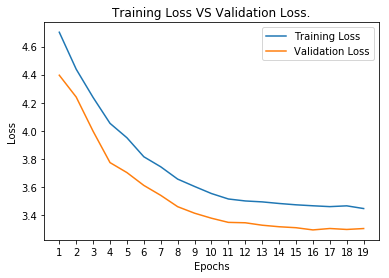

Image saved!


In [208]:
import numpy as np
plt.title("Training Loss VS Validation Loss.")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(range(1,20),history['train_loss'],label="Training Loss")
plt.plot(range(1,20),history['val_loss'],label="Validation Loss")

plt.xticks(np.arange(1, 20, 1.0))
plt.legend()
plt.show()

plt.savefig('Training Loss VS Validation Loss - model scratch.png')
print('Image saved!')

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [209]:
## TODO: Specify data loaders
loaders_transfer = loaders_data

In [210]:
loaders_transfer

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe125bba7b8>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fe125bbad68>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe125bba080>}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [211]:
## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

In [212]:
n_features = model_transfer.classifier[6].in_features
model_transfer.classifier[6] = nn.Linear(n_features, hparameters['n_classes'])

In [213]:
if use_cuda:
    model_transfer = model_transfer.cuda()

In [180]:
#model.summary()
summary(model_transfer, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- The first time a pre-trained model is loaded, pytoch will download the required model weights. 
- the model expects color input images to be rescaled to the size of 224×224 squares.
- load weight of VGG16 from IMAGENET and freeze all the layers.
- creating a new output layer to fit my application.
- create a copy from loaders_data.
- compile the model with SGD optimizer and CrossEntropyLoss loss function.
- train the model and save it after each increasing of its accuracy.
- test the model on the test sample.
- visualize the loss and accuracy of the validation and trainig sets.
- make a comparison between model scratch and model transfer accuracy.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [214]:
params_to_update = []

for name, param in model_transfer.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = torch.optim.SGD(params_to_update,
                                      lr=hparameters['learning_rate'],
                                     momentum = hparameters['momentum'])

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [215]:
# train the model
transfer_history, model_transfer = train(
                                        hparameters['n_epochs'],
                                        model_transfer,loaders_transfer,
                                        criterion_transfer,optimizer_transfer, use_cuda, 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 1/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 3.676616 	 Accuracy: 0.604790
-----------
valid epoch 	 Loss: 1.430748 	 Accuracy: 0.828743
------------------------------------------------------------------------------------

Validation loss decreased (inf ----> 1.430748)  Saving model...
Epoch takes 3 min 52 sec
Epoch 2/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 3.644826 	 Accuracy: 0.608832
-----------
valid epoch 	 Loss: 1.280674 	 Accuracy: 0.855090
------------------------------------------------------------------------------------

Validation loss decreased (1.430748 ----> 1.280674)  Saving model...
Epoch takes 3 min 53 sec
Epoch 3/50
------------------------------------------------------------------------------------
train epoch 	 Loss: 3.552361 	 Accuracy: 0.618413
-----------
valid epoch 	 Loss: 1.346600 	 Accuracy: 0.849102
Epoch takes 3 min 52 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [216]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

------------------------------------------
Test Loss: 2.369591


Test Accuracy: 72% (605/836)


### (VISUALIZATION) visual accuarcy and losses using matplotlib

In [218]:
np.save('model_transfer_history.npy', transfer_history) 

In [219]:
transfer_history = np.load('model_transfer_history.npy',allow_pickle='TRUE').item()
transfer_history

{'train_acc': [tensor(0.6048, dtype=torch.float64, device='cuda:0'),
  tensor(0.6088, dtype=torch.float64, device='cuda:0'),
  tensor(0.6184, dtype=torch.float64, device='cuda:0'),
  tensor(0.6157, dtype=torch.float64, device='cuda:0'),
  tensor(0.6235, dtype=torch.float64, device='cuda:0')],
 'train_loss': [3.6766161599648215,
  3.6448264200530365,
  3.5523605036164474,
  3.664177071057751,
  3.60473902978583],
 'val_acc': [tensor(0.8287, dtype=torch.float64, device='cuda:0'),
  tensor(0.8551, dtype=torch.float64, device='cuda:0'),
  tensor(0.8491, dtype=torch.float64, device='cuda:0'),
  tensor(0.8527, dtype=torch.float64, device='cuda:0'),
  tensor(0.8443, dtype=torch.float64, device='cuda:0')],
 'val_loss': [1.43074799743955,
  1.2806743717791436,
  1.346599509437641,
  1.3967909289825104,
  1.2952715824553354],
 'learning_rate': [0.01, 0.01, 0.01, 0.01]}

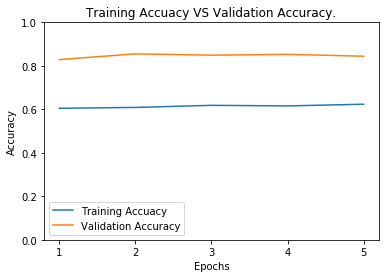

Image saved!


In [223]:
train_acc = []
valid_acc = []
epochs = 6

train_acc = [acc.cpu().numpy() for acc in transfer_history['train_acc']]
valid_acc = [acc.cpu().numpy() for acc in transfer_history['val_acc']]

plt.title("Training Accuacy VS Validation Accuracy.")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,epochs),train_acc,label="Training Accuacy")
plt.plot(range(1,epochs),valid_acc,label="Validation Accuracy")
plt.ylim((0,1))
plt.xticks(np.arange(1, epochs, 1.0))
plt.legend()
plt.show()

plt.savefig('Training Accuacy VS Validation Accuracy - pretrained scratch.png')
print('Image saved!')

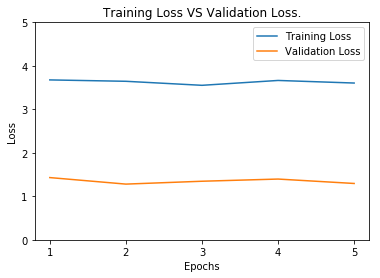

Image saved!


In [232]:
import numpy as np
plt.title("Training Loss VS Validation Loss.")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(range(1, epochs),transfer_history['train_loss'],label="Training Loss")
plt.plot(range(1, epochs),transfer_history['val_loss'],label="Validation Loss")
plt.ylim((0,5))

plt.xticks(np.arange(1, epochs, 1.0))
plt.legend()
plt.show()

plt.savefig('Training Loss VS Validation Loss - pretrained scratch.png')
print('Image saved!')

###  Comparison with Model Trained from Scratch and model transfer

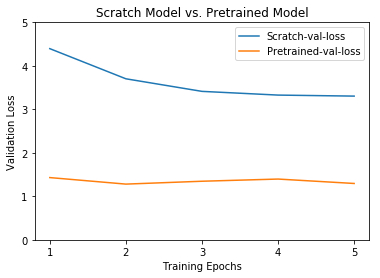

Image saved!


In [241]:
scratch_val_Acc = []
pretrained_val_Acc = []

plt.plot(range(1, epochs),history['val_loss'][0:-1:4],label="Scratch-val-loss")
plt.plot(range(1, epochs),transfer_history['val_loss'],label="Pretrained-val-loss")
plt.ylim((0,5))

plt.title("Scratch Model vs. Pretrained Model")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")

plt.xticks(np.arange(1, epochs, 1.0))
plt.legend()

plt.show()
plt.savefig('Scratch Model vs. Pretrained Model.png')
print('Image saved!')

### Visualizing Convolutional Layer weights

In [53]:
from extractor import Extractor

extractor = Extractor(list(model_transfer.children()))
extractor.activate()
extractor.info()

{'Down-sample layers name': 'downsample',
 'Total CNN Layers': 1,
 'Total Sequential Layers': 1,
 'Total Downsampling Layers': 0,
 'Total Linear Layers': 1,
 'Total number of Bottleneck and Basicblock': 0,
 'Total Execution time': '0.00038 sec'}

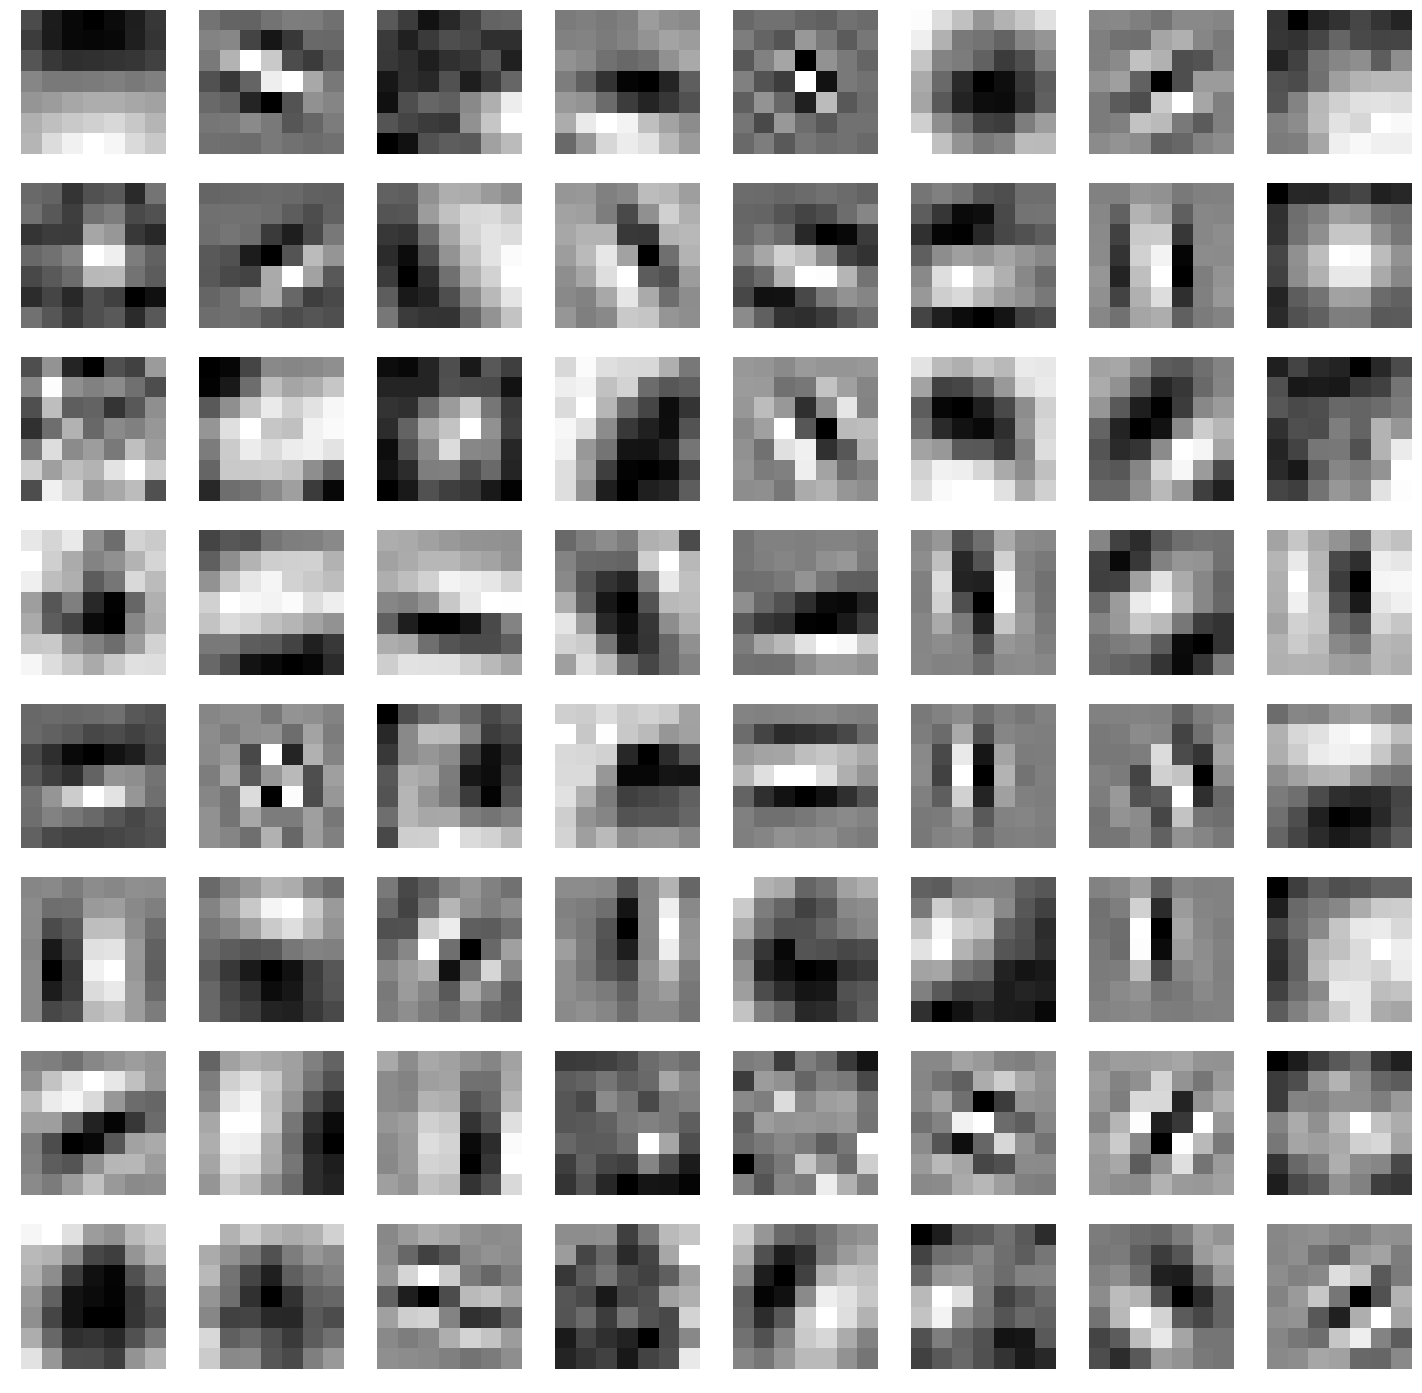

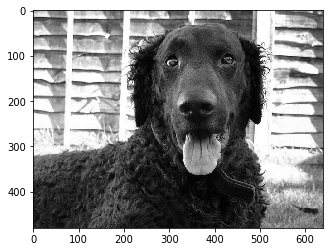

In [55]:
# Visualising the filters
import cv2
import torchvision.transforms as transforms

plt.figure(figsize=(25, 25))
for index, filter in enumerate(extractor.CNN_weights[0]):
    if index == 64:
        break
    plt.subplot(8, 8, index + 1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()
img = cv2.cvtColor(cv2.imread('./images/Curly-coated_retriever_03896.jpg'), cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()



### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [119]:
loaders_transfer = loaders_data

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path , model):
    
    img = Image.open(img_path)
    trans = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(244),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,.5),(0.5,0.5,0.5))])

    img = trans(img)[:3,:,:].unsqueeze(0)

    if use_cuda:
        model = model.cuda()
        img = img.cuda()

    model.eval()
    class_ = model(img)
    output = class_names[torch.argmax(class_)]

    return output

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [132]:
def run_app(img_path):
    # Detect if the photo id dog or not 
    if dog_detector(img_path, VGG16_model) :
        #Say Hallo for the dog ^^
        print("Hello, Dog")
        #Predict the Dog breed 
        Class = predict_breed_transfer(img_path , model_transfer)
        #Print the image 
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()
        print("The breed of the dog is :", Class)
        print("="*50)
        
    elif face_detector(img_path) :
        #Say Hello for the human^^
        print("Hello, Human")
        #Predict the human  resamplig of the dog breed
        Class = predict_breed_transfer(img_path , model_transfer)
        #Print the image 
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()
        print("You look like :", Class)
        print("="*50)
    else :
        print("The image is neither dog nor human there is an error ")
        img = mpimg.imread(img_path)
        imgplot = plt.imshow(img)
        plt.axis('off')
        plt.show()
        print("="*50)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The results are a bit disappointing and I think that these 3 points can improve the result.

- Make a model to predict faces or using **MTCNN** insted of OpenCV's implementation of **Haar feature-based cascade** classifiers as this model has a high cost.

- adjust the learning rate based on the number of epochs. **torch.optim.lr_scheduler** allows dynamic learning rate reducing based on some validation measurements.

- I think that the last few pre-trained model need to be re-trained insted of re-train only the last one.

Hello, Human


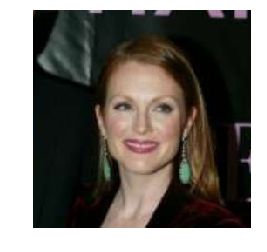

You look like : Cocker spaniel
Hello, Human


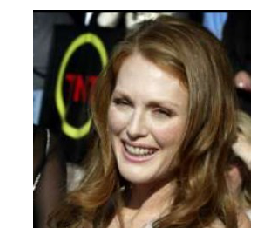

You look like : Cocker spaniel
Hello, Dog


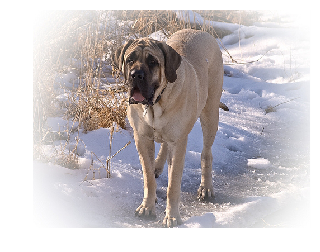

The breed of the dog is : Mastiff
Hello, Dog


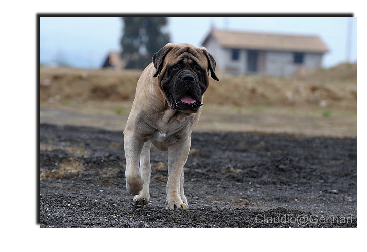

The breed of the dog is : Mastiff


In [133]:
# Create list of test image paths

for file in np.hstack((human_files[50:52], dog_files[50:52])):
    run_app(file)

The image is neither dog nor human there is an error 


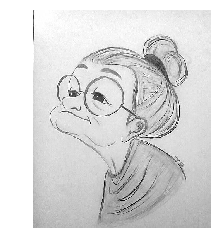

Hello, Human


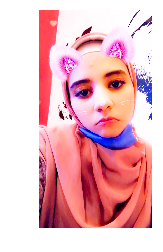

You look like : Japanese chin
Hello, Human


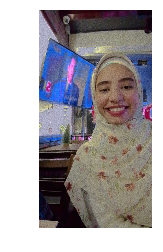

You look like : Dachshund
The image is neither dog nor human there is an error 


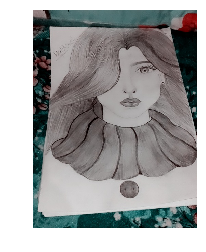

The image is neither dog nor human there is an error 


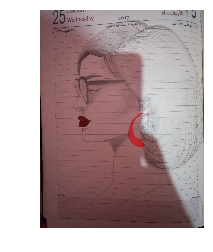

The image is neither dog nor human there is an error 


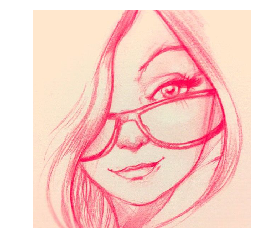

Hello, Human


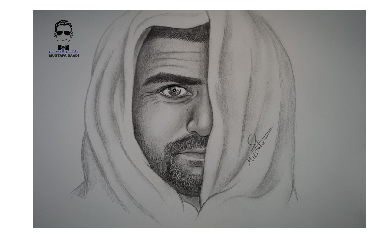

You look like : Chinese shar-pei
The image is neither dog nor human there is an error 


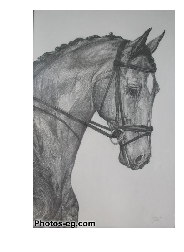

In [134]:
run_app('easy how to draw.jpeg') 
run_app('heba.jpg')
run_app('heba2.jpg')
run_app('drawing1.jpg')
run_app('drawing2.png')  
run_app('image1.jpg')
run_app('image2.jpg')  
run_app('horse.jpg') 

## OPTIONAL: Question for the reviewer
If you have any question about the starter code or your own implementation, please add it in the cell below. 


For example, if you want to know why a piece of code is written the way it is, or its function, or alternative ways of implementing the same functionality, or if you want to get feedback on a specific part of your code or get feedback on things you tried but did not work.


Please keep your questions succinct and clear to help the reviewer answer them satisfactorily.